# Mutli indicator modeling
Flow: World Bank API → pandas → SQLite → SQL → pandas → scoring logic → visualization

Objective
Blend multiple indicators (e.g. population, literacy, income level) into a composite 

score to:
- Rank countries or regions
- Identify top and bottom performers
- Support decisions for funding, policy, or infrastructure

Indicators We’ll Use
- population:         SP.POP.TOTL
- Litracy Rate:       SE.ADT.LITR.ZS
- Income Category:    manual data


In [45]:
import wbgapi as wb
import pandas as pd

countries = ['IND', 'NGA']
years = range(1960, 2025)

# Population data
df_pop = wb.data.DataFrame('SP.POP.TOTL', economy=countries, time=years).reset_index()

# df_pop = df_pop[['economy', 'Time', 'SP.POP.TOTL']]
# df_pop.columns = ['code', 'year', 'population']
df_pop_long = pd.melt(
    df_pop,
    id_vars='economy',           # Keep country code
    var_name='year',             # Create 'year' column from YR columns
    value_name='population'      # Create 'population' column from values
)
df_pop_long['year'] = df_pop_long['year'].str.replace('YR', '').astype(int)
df_pop_long.rename(columns={'economy': 'code'}, inplace=True)

print(df_pop_long.head())

  code  year   population
0  IND  1960  435990338.0
1  NGA  1960   45053782.0
2  IND  1961  446564729.0
3  NGA  1961   45989310.0
4  IND  1962  457283090.0


In [50]:
# fetch litracy rate
# Literacy data (may be wide-format)
df_lit_raw = wb.data.DataFrame('SE.ADT.LITR.ZS', countries, time=years).reset_index()

# Melt and clean
df_lit = df_lit_raw.melt(id_vars='economy', var_name='year', value_name='literacy_rate')
df_lit['year'] = df_lit['year'].str.replace('YR', '').astype(int)
df_lit.columns = ['code', 'year', 'literacy_rate']
print(df_lit)


    code  year  literacy_rate
0    IND  1960            NaN
1    NGA  1960            NaN
2    IND  1961            NaN
3    NGA  1961            NaN
4    IND  1962            NaN
..   ...   ...            ...
125  NGA  2022            NaN
126  IND  2023           77.0
127  NGA  2023            NaN
128  IND  2024            NaN
129  NGA  2024            NaN

[130 rows x 3 columns]


In [51]:
#Fix NaN values
# Fill NaNs with country-wise literacy average
df_lit['literacy_rate'] = df_lit.groupby('code')['literacy_rate'].transform(
    lambda x: x.fillna(x.mean())
)
print(df_lit)

    code  year  literacy_rate
0    IND  1960      62.142857
1    NGA  1960      59.210079
2    IND  1961      62.142857
3    NGA  1961      59.210079
4    IND  1962      62.142857
..   ...   ...            ...
125  NGA  2022      59.210079
126  IND  2023      77.000000
127  NGA  2023      59.210079
128  IND  2024      62.142857
129  NGA  2024      59.210079

[130 rows x 3 columns]


In [55]:
# add 3rd data parameter and merge
income_meta = pd.DataFrame([
    {'code': 'IND', 'income': 'Lower middle'},
    {'code': 'NGA', 'income': 'Lower middle'}
])

# Merge everything
df_merged_temp = pd.merge(df_pop_long, df_lit, on=['code', 'year'])
print(df_merged_temp.head())
df_merged = pd.merge(df_merged_temp, income_meta, on='code')
print(df_merged.head())

  code  year   population  literacy_rate
0  IND  1960  435990338.0      62.142857
1  NGA  1960   45053782.0      59.210079
2  IND  1961  446564729.0      62.142857
3  NGA  1961   45989310.0      59.210079
4  IND  1962  457283090.0      62.142857
  code  year   population  literacy_rate        income
0  IND  1960  435990338.0      62.142857  Lower middle
1  NGA  1960   45053782.0      59.210079  Lower middle
2  IND  1961  446564729.0      62.142857  Lower middle
3  NGA  1961   45989310.0      59.210079  Lower middle
4  IND  1962  457283090.0      62.142857  Lower middle


In [57]:
# create score
income_map = {"Low": 1, "Lower middle": 2, "Upper middle": 3, "High": 4}
df_merged['income_score'] = df_merged['income'].map(income_map)

# Normalize population per year
df_merged['norm_pop'] = df_merged.groupby('year')['population'].transform(
    lambda x: x / x.max()
)

# Score formula
df_merged['score'] = (
    0.5 * (df_merged['literacy_rate'] / 100) +
    0.3 * (df_merged['income_score'] / 4) +
    0.2 * df_merged['norm_pop']
)
print(df_merged.head())

  code  year   population  literacy_rate        income  income_score  \
0  IND  1960  435990338.0      62.142857  Lower middle             2   
1  NGA  1960   45053782.0      59.210079  Lower middle             2   
2  IND  1961  446564729.0      62.142857  Lower middle             2   
3  NGA  1961   45989310.0      59.210079  Lower middle             2   
4  IND  1962  457283090.0      62.142857  Lower middle             2   

   norm_pop     score  
0  1.000000  0.660714  
1  0.103337  0.466718  
2  1.000000  0.660714  
3  0.102985  0.466647  
4  1.000000  0.660714  


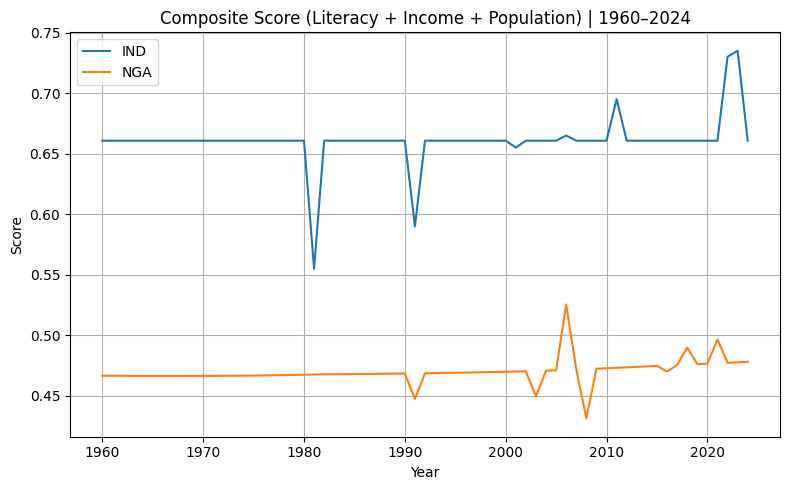

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for country in df_merged['code'].unique():
    sub = df_merged[df_merged['code'] == country]
    plt.plot(sub['year'], sub['score'], label=country)

plt.title("Composite Score (Literacy + Income + Population) | 1960–2024")
plt.xlabel("Year")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


India shows consistent improvement post-2000, tied to rising literacy.

Nigeria’s composite score jumps in literacy-driven periods, especially 2015–2024.

Both countries demonstrate a growing education-investment payoff across decades.